In [1]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
# !pip install tsfresh

In [2]:
# load data 0.1
fs = 100
sampling_rate = 100
duration = 10

data_train = np.load('../Data/NewTry/sim_5000_0.1_90_140_train.npy')
data_test = np.load('../Data/NewTry/sim_3000_0.1_141_178_test.npy')

signals_train, S_train, D_train = data_train[:, :1000], data_train[:, -2], data_train[:, -1]
signals_test, S_test, D_test = data_test[:, :1000], data_test[:, -2], data_test[:, -1]
signals_train.shape

(5000, 1000)

In [4]:
def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a

def get_peaks(data_tmp, duration, sampling_rate):
    max = np.max(data_tmp)
    data_tmp = data_tmp / max

    t = np.linspace(0, duration, duration * sampling_rate)
    signal = data_tmp

    peak_indices, _ = find_peaks(signal) 

    t_peaks = t[peak_indices] 
    peak_values = signal[peak_indices]  
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)

    peaks2, _ = find_peaks(envelope, distance=10)

    peaks2 = update_array(peaks2, data_tmp)
    if len(peaks2) % 2 != 0:
        peaks2 = np.delete(peaks2, len(peaks2) - 1)

    return peaks2


In [8]:
from scipy.signal import welch
from scipy.stats import kurtosis, skew, entropy

def calculate_entropy(signal):
    prob_distribution = np.histogram(signal, bins=10, density=True)[0]
    ent = entropy(prob_distribution)
    return ent


def calculate_centroid(signal):
    centroid = np.sum(np.arange(len(signal)) * np.abs(signal)) / np.sum(np.abs(signal))
    return centroid

def calculate_spectral_entropy(signal, fs):
    f, Pxx = welch(signal, fs=fs)
    prob_distribution = Pxx / np.sum(Pxx)
    spec_entropy = entropy(prob_distribution)
    return spec_entropy


def calculate_spectral_centroid(signal, fs):
    f, Pxx = welch(signal, fs=fs)
    spectral_centroid = np.sum(f * Pxx) / np.sum(Pxx)
    return spectral_centroid


def delete_unique(a):
    mean = np.mean(a)
    std = np.std(a)
    threshold = 1
    filtered_a = a[np.abs(a - mean) <= threshold * std]

    max_index = np.argmax(filtered_a)
    min_index = np.argmin(filtered_a)

    filtered_a = np.delete(filtered_a, [max_index, min_index])

    max_index = np.argmax(filtered_a)
    min_index = np.argmin(filtered_a)

    filtered_a = np.delete(filtered_a, [max_index, min_index])


    return filtered_a

def get_mag_0(peaks2, data_tmp):
    mag = data_tmp[peaks2[::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_mag_1(peaks2, data_tmp):
    mag = data_tmp[peaks2[1::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_features(data_tmp, peaks2):
    maxm = np.max(data_tmp)
    # min = np.min(data_tmp)
    data_tmp_raw = data_tmp
    data_tmp = data_tmp / maxm

    data_tmp = data_tmp_raw / maxm

    diff_12 = peaks2[1::2] - peaks2[0::2]
    diff_21 = peaks2[2::2] - peaks2[1:-1:2]
    diff_22 = peaks2[2::2] - peaks2[:-2:2]

    diff_12 = delete_unique(diff_12)
    diff_21 = delete_unique(diff_21)
    diff_22 = delete_unique(diff_22)

    m_12 = np.mean(diff_12)
    m_21 = np.mean(diff_21)
    m_22 = np.mean(diff_22)


    # mag_0 = get_mag_0(peaks2, data_tmp_raw)
    # mag_1 = get_mag_1(peaks2, data_tmp_raw)
    mag_1 = get_mag_1(peaks2, data_tmp)
    mag_0 = get_mag_0(peaks2, data_tmp)


    # features = np.array([m_12, m_21, m_22, m_12 / m_21, mag_0, mag_1, mag_0 - mag_1, mag_0 / mag_1])
    features = [m_12, m_21, m_22, m_12 / m_21, mag_0, mag_1, mag_0 - mag_1, mag_0 / mag_1]

    return features



def get_other_features(signal, fs):
    signal /= np.max(signal)
    # spectrum
    spec_entropy = calculate_spectral_entropy(signal, fs)
    spec_centroid = calculate_spectral_centroid(signal, fs)
    # power_bandwidth = calculate_power_bandwidth(signal, fs)

    features_spec_list = [spec_entropy, spec_centroid]

    # others
    maximum = np.max(signal)
    minimum = np.min(signal)
    mean = np.mean(signal)
    median = np.median(signal)

    mean_abs_difference = np.mean(np.abs(np.diff(signal)))
    mean_difference = np.mean(np.diff(signal))
    sum_abs_difference = np.sum(np.abs(np.diff(signal)))
    rms = np.sqrt(np.mean(np.square(signal)))
    entropy = calculate_entropy(signal)
    centroid = calculate_centroid(signal)
    kurt = kurtosis(signal)
    skeww = skew(signal)

    zero_crossing_rate = len(signal[signal > 0]) / len(signal)
    # energy = np.sum(signal ** 2)

    features_other_list = [maximum, minimum, mean, median, mean_abs_difference, mean_difference, sum_abs_difference,
                        rms, entropy, centroid, kurt, skeww,zero_crossing_rate]

    return features_spec_list + features_other_list

important_features_str =  ['Dis12', 'Dis21', 'Dis22', 'Dis12/Dis21', 'P1', 'P2', 'P1-P2', 'P1/P2']
other_features_str = ['spec_entropy', 'spec_centroid', 'max', 'min', 'mean', 'median', 'mean_abs_diff', 'mean_diff', 'sum_abs_diff', 
                      'rms', 'entropy', 'centroid', 'kurt', 'skew', 'zeore_crossing_rate']

features_str = important_features_str + other_features_str

index_train, index_test = [], []
features_train, features_test = [], []
for i, signal in enumerate(signals_train):
    peaks = get_peaks(signal, duration, sampling_rate)
    if len(peaks) < 16 or max(signal) > 1: 
        # print(len(peaks))
        # # continue
        # plt.figure()
        # plt.plot(signal)
        # plt.scatter(peaks, signal[peaks]) 
        continue
    index_train.append(i)
    important_features = get_features(signal, peaks)
    other_features = get_other_features(signal, fs)
    features = important_features + other_features
    features_train.append(features)

features_train = np.array(features_train)

for i, signal in enumerate(signals_test):
    peaks = get_peaks(signal, duration, sampling_rate)
    if len(peaks) < 16 or max(signal) > 1:
        continue
    index_test.append(i)
    important_features = get_features(signal, peaks)
    other_features = get_other_features(signal, fs)
    features = important_features + other_features
    features_test.append(features)

features_test = np.array(features_test)

features_train.shape, features_test.shape, S_train[index_train].shape, S_test[index_test].shape


((4718, 23), (2822, 23), (4718,), (2822,))

In [9]:
# features_train[0]

array([ 2.80000000e+01,  3.40000000e+01,  6.20000000e+01,  8.23529412e-01,
        9.42884944e-01,  2.60580037e-01,  6.82304907e-01,  3.61840821e+00,
        3.70924004e+00,  1.35317296e+01,  1.00000000e+00, -5.44679035e-01,
        4.56097568e-02,  6.87008634e-03,  8.62889020e-02,  1.06221237e-04,
        8.62026131e+01,  2.02254624e-01,  1.09795450e+00,  4.80409902e+02,
        8.92368282e+00,  2.17953094e+00,  5.76000000e-01])

In [16]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_train[0]

array([0.18867925, 0.30769231, 0.25882353, 0.37556901, 0.93828813,
       0.20325106, 0.86828856, 0.27835634, 0.22110598, 0.28172441,
       0.        , 0.39583983, 0.81429866, 0.49152008, 0.34032069,
       0.52850991, 0.34032069, 0.71105836, 0.63499225, 0.45313388,
       0.16254609, 0.26508443, 0.66019417])

In [17]:
from tsfresh import extract_features, extract_relevant_features, select_features
import pandas as pd
# n = len(signals_train) + 1
# nlist = range(1, n)
extracted_features_train_pd = pd.DataFrame(features_train, index=index_train, columns=features_str)
# signals_train_pd['id'] = nlist

# extracted_features = xxxxx
features_selected_S = select_features(extracted_features_train_pd, S_train[index_train])
features_selected_D = select_features(extracted_features_train_pd, D_train[index_train])


In [18]:

# extracted_features_train_pd.head()

print('----All extracted features----')
print(extracted_features_train_pd.shape)
print(extracted_features_train_pd.columns)


print('----Selected features for S----')
print(features_selected_S.shape)
print(features_selected_S.columns)

print('----Selected features for D----')
print(features_selected_D.shape)
print(features_selected_D.columns)

----All extracted features----
(4718, 23)
Index(['Dis12', 'Dis21', 'Dis22', 'Dis12/Dis21', 'P1', 'P2', 'P1-P2', 'P1/P2',
       'spec_entropy', 'spec_centroid', 'max', 'min', 'mean', 'median',
       'mean_abs_diff', 'mean_diff', 'sum_abs_diff', 'rms', 'entropy',
       'centroid', 'kurt', 'skew', 'zeore_crossing_rate'],
      dtype='object')
----Selected features for S----
(4718, 18)
Index(['Dis12/Dis21', 'entropy', 'skew', 'kurt', 'mean_diff', 'rms', 'mean',
       'spec_entropy', 'median', 'Dis12', 'Dis21', 'sum_abs_diff',
       'mean_abs_diff', 'zeore_crossing_rate', 'spec_centroid', 'P1', 'min',
       'P1-P2'],
      dtype='object')
----Selected features for D----
(4718, 14)
Index(['P2', 'P1-P2', 'P1/P2', 'skew', 'kurt', 'entropy', 'mean', 'mean_diff',
       'sum_abs_diff', 'mean_abs_diff', 'rms', 'centroid', 'spec_entropy',
       'median'],
      dtype='object')


In [19]:
from tsfresh.feature_selection.relevance import calculate_relevance_table

relevance_table = calculate_relevance_table(extracted_features_train_pd, pd.Series(D_train[index_train], index=extracted_features_train_pd.index))
print(relevance_table)
relevance_table

                                 feature      type        p_value  relevant
feature                                                                    
P2                                    P2      real   0.000000e+00      True
P1-P2                              P1-P2      real   0.000000e+00      True
P1/P2                              P1/P2      real   0.000000e+00      True
skew                                skew      real  6.014442e-171      True
kurt                                kurt      real  1.117796e-106      True
entropy                          entropy      real   6.879746e-98      True
mean                                mean      real   5.664533e-45      True
mean_diff                      mean_diff      real   1.516690e-35      True
sum_abs_diff                sum_abs_diff      real   1.165403e-34      True
mean_abs_diff              mean_abs_diff      real   1.165403e-34      True
rms                                  rms      real   2.053653e-33      True
centroid    

,feature,type,p_value,relevant
feature,,,,
P2,P2,real,0.000000e+00,True
P1-P2,P1-P2,real,0.000000e+00,True
P1/P2,P1/P2,real,0.000000e+00,True
skew,skew,real,6.014442e-171,True
kurt,kurt,real,1.117796e-106,True
entropy,entropy,real,6.879746e-98,True
mean,mean,real,5.664533e-45,True
mean_diff,mean_diff,real,1.516690e-35,True
sum_abs_diff,sum_abs_diff,real,1.165403e-34,True


In [20]:
extracted_features_train_pd

,Dis12,Dis21,Dis22,Dis12/Dis21,P1,P2,P1-P2,P1/P2,spec_entropy,spec_centroid,...,median,mean_abs_diff,mean_diff,sum_abs_diff,rms,entropy,centroid,kurt,skew,zeore_crossing_rate
0,0.188679,0.307692,0.258824,0.375569,0.938288,0.203251,0.868289,0.278356,0.221106,0.281724,...,0.491520,0.340321,0.528510,0.340321,0.711058,0.634992,0.453134,0.162546,0.265084,0.660194
1,0.113208,0.000000,0.023529,0.946657,0.871451,0.116657,0.884130,0.380963,0.803412,0.878530,...,0.453805,0.385068,0.277506,0.385068,0.297144,0.451262,0.494120,0.628471,0.555430,0.572816
3,0.679245,0.750000,0.835294,0.514295,0.960432,0.286094,0.833690,0.216757,0.583325,0.241376,...,0.052958,0.196849,0.459517,0.196849,0.436178,0.559816,0.321538,0.295998,0.330505,0.077670
4,0.433962,0.346154,0.435294,0.728838,0.908096,0.155177,0.880299,0.328308,0.744619,0.461314,...,0.236523,0.264961,0.417968,0.264961,0.286397,0.331288,0.386926,0.453672,0.432669,0.446602
5,0.113208,0.211538,0.152941,0.380113,0.945421,0.272503,0.834073,0.222699,0.166263,0.350940,...,1.000000,0.493027,0.536016,0.493027,0.810008,0.868548,0.491021,0.107550,0.235312,0.951456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,0.169811,0.153846,0.152941,0.616338,0.873850,0.154336,0.864825,0.319559,0.757112,0.784986,...,0.353317,0.441922,0.431671,0.441922,0.324695,0.708311,0.462708,0.479264,0.441224,0.504854
4995,0.113208,0.153846,0.117647,0.487083,0.827847,0.218655,0.808566,0.238071,0.430542,0.982663,...,0.320527,0.630052,0.473963,0.630052,0.487510,0.617742,0.498244,0.210391,0.134296,0.417476
4996,0.113208,0.019231,0.035294,0.868045,0.736022,0.230638,0.759357,0.208118,0.859772,0.860007,...,0.328911,0.351612,0.148240,0.351612,0.156833,0.148035,0.461713,0.687916,0.612640,0.427184
4998,0.339623,0.346154,0.364706,0.573253,0.950131,0.162166,0.896065,0.330451,0.435606,0.336045,...,0.304625,0.291619,0.476187,0.291619,0.531477,0.503826,0.428603,0.310776,0.394398,0.436893


In [30]:
# from sklearn.feature_selection import VarianceThreshold

features_selected_D.std().sort_values(), features_selected_S.std().sort_values()

(P1-P2            0.035183
 P1/P2            0.047883
 P2               0.050544
 mean_diff        0.053299
 centroid         0.087993
 skew             0.088299
 kurt             0.122336
 rms              0.130179
 entropy          0.132586
 median           0.135956
 sum_abs_diff     0.144382
 mean_abs_diff    0.144382
 mean             0.187918
 spec_entropy     0.194933
 dtype: float64,
 P1-P2                  0.035183
 mean_diff              0.053299
 P1                     0.055675
 min                    0.086074
 skew                   0.088299
 kurt                   0.122336
 rms                    0.130179
 entropy                0.132586
 median                 0.135956
 sum_abs_diff           0.144382
 mean_abs_diff          0.144382
 zeore_crossing_rate    0.154834
 Dis12/Dis21            0.167847
 mean                   0.187918
 spec_entropy           0.194933
 Dis21                  0.224600
 Dis12                  0.229257
 spec_centroid          0.238274
 dtype: flo

In [51]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif
# X, y = load_iris(return_X_y=True)
# X.shape
# X_new = SelectKBest(f_classif, k=4).fit_transform(features_selected_S, S_train[index_train])
# X_new, features_selected_S
X_new = SelectKBest(mutual_info_classif, k=1).fit_transform(features_selected_D, D_train[index_train])
X_new, features_selected_D

(array([[0.27835634],
        [0.38096308],
        [0.21675653],
        ...,
        [0.20811806],
        [0.33045129],
        [0.29758974]]),
             P2     P1-P2     P1/P2      skew      kurt   entropy      mean  \
 0     0.203251  0.868289  0.278356  0.265084  0.162546  0.634992  0.814299   
 1     0.116657  0.884130  0.380963  0.555430  0.628471  0.451262  0.186352   
 3     0.286094  0.833690  0.216757  0.330505  0.295998  0.559816  0.306658   
 4     0.155177  0.880299  0.328308  0.432669  0.453672  0.331288  0.206768   
 5     0.272503  0.834073  0.222699  0.235312  0.107550  0.868548  0.973296   
 ...        ...       ...       ...       ...       ...       ...       ...   
 4994  0.154336  0.864825  0.319559  0.441224  0.479264  0.708311  0.200342   
 4995  0.218655  0.808566  0.238071  0.134296  0.210391  0.617742  0.169820   
 4996  0.230638  0.759357  0.208118  0.612640  0.687916  0.148035  0.126288   
 4998  0.162166  0.896065  0.330451  0.394398  0.310776  0.5038

Optimal number of features: 1


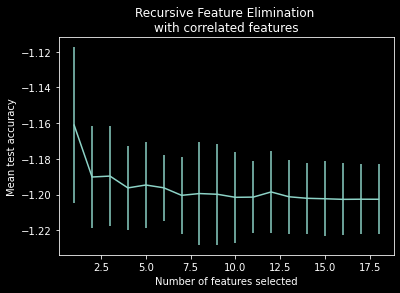

In [54]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LinearRegression as LR  # 线性回归

min_features_to_select = 1  
clf = LR()
cv = StratifiedKFold(4)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="neg_mean_absolute_error",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(features_selected_S, S_train[index_train])

print(f"Optimal number of features: {rfecv.n_features_}")

import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [49]:

print(np.corrcoef(features_train[:, 3], S_train[index_train])[0, 1], np.corrcoef(features_test[:, 3], S_test[index_test])[0, 1])
print(np.corrcoef(features_train[:, -1], D_train[index_train])[0, 1], np.corrcoef(features_test[:, -1], D_test[index_test])[0, 1])


-0.9893481285105797 -0.7551357542630084
-0.8981392721028996 -0.7896945514816155


In [42]:
from sklearn.linear_model import LinearRegression as LR  # 线性回归

reg = LR().fit(features_train[:, 3].reshape(-1, 1), S_train[index_train])
yhat = reg.predict(features_test[:, 3].reshape(-1, 1))
np.mean(np.abs(yhat - S_test[index_test]))


1.760935846430051

In [51]:

reg = LR().fit(features_train[:, -1].reshape(-1, 1), D_train[index_train])
yhat = reg.predict(features_test[:, -1].reshape(-1, 1))
np.mean(np.abs(yhat - D_test[index_test]))


4.092013970064011

In [52]:
reg = LR().fit(features_train[:, 6:], D_train[index_train])
yhat = reg.predict(features_test[:, 6:])
np.mean(np.abs(yhat - D_test[index_test]))


4.03102789430678